In [1]:
import numpy as np 
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
X_train = pd.read_csv('../data/X_train.csv', sep=',', encoding='utf-8')

In [3]:
print(len(X_train))
X_train['sepostulo'].head(2)

13098946


0    True
1    True
Name: sepostulo, dtype: bool

In [4]:
# Desordenamos para que no queden todos los true primero y los false despues
X_train = X_train.sample(len(X_train))

In [5]:
X_train['sepostulo'].head(10)

8245057     False
3395322      True
5360294      True
5879119      True
2031994      True
182043       True
11374338    False
3989780      True
10498444    False
5491039      True
Name: sepostulo, dtype: bool

In [6]:
target = X_train[['sepostulo']]

In [7]:
X_train.to_csv('../data/X_train.csv', index=False, sep=',', encoding='utf-8')
target.to_csv('../data/target.csv', index=False, sep=',', encoding='utf-8')

In [15]:
target = pd.read_csv('../data/target.csv', sep=',', encoding='utf-8')

In [2]:
X_train = pd.read_csv('../data/X_train.csv', sep=',', encoding='utf-8')

In [8]:
X_test = pd.read_csv('../data/X_test.csv', sep=',', encoding='utf-8')

In [9]:
X_test.shape

(100120, 55)

In [10]:
print('train shape:', X_train.shape,'| target shape:', target.shape)
print('test shape:', X_test.shape)

train shape: (13098946, 56) | target shape: (13098946, 1)
test shape: (100120, 55)


In [11]:
X_test.duplicated('id').any()

True

In [12]:
X_test.head(1)

,id,idaviso,idpostulante,edad,nombre_estudio_Doctorado,nombre_estudio_Master,nombre_estudio_Otro,nombre_estudio_Posgrado,nombre_estudio_Secundario,nombre_estudio_Terciario/Tecnico,nombre_estudio_Universitario,estado_estudio_Abandonado,estado_estudio_EnCurso,estado_estudio_Graduado,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,nombre_area,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,cant_vistas_aviso,cant_postulaciones_aviso,tipo_full,tipo_part,tipo_otro,nivel_laboral_Gerencia/AltaGerencia/Dirección,nivel_laboral_Jefe/Supervisor/Responsable,nivel_laboral_Junior,nivel_laboral_Otro,nivel_laboral_Senior/Semi-Senior,Ventas,Administración,Producción,Comercial,AtenciónalCliente,Recepcionista,CallCenter,Tesorería,Telemarketing,MantenimientoyLimpieza,Almacén/Depósito/Expedición,Contabilidad,RecursosHumanos,Gastronomia,Logística,Secretaria,AdministracióndePersonal,CréditosyCobranzas,Marketing,Legal
0,0,739260,6M9ZQR,42,1,0,0,0,0,0,0,0,0,1,1,0,0,Comercial,0,1,0,0,0,0,0,2,0,True,False,False,0,1,0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [13]:
X_test.drop_duplicates(['idaviso', 'idpostulante'], inplace=True, keep='last')
X_test.shape

(100000, 55)

In [14]:
ids = X_test[['id']]

In [15]:
X_test.drop('id', axis=1, inplace=True)

In [16]:
print('train shape:', X_train.shape,'| target shape:', target.shape)
print('test shape:', X_test.shape)

train shape: (13098946, 56) | target shape: (13098946, 1)
test shape: (100000, 54)


In [17]:
ids.to_csv('test_.csv', sep=',', encoding='utf-8')

In [18]:
print(X_train.shape)
print(X_test.shape)

(13098946, 56)
(100000, 54)


In [19]:
print(len(target[target['sepostulo'] == False]))
print(len(target[target['sepostulo'] == True]))

6495194
6603752


In [20]:
X_train.head(1)

,Administración,AdministracióndePersonal,Almacén/Depósito/Expedición,AtenciónalCliente,CallCenter,Comercial,Contabilidad,CréditosyCobranzas,Gastronomia,Legal,Logística,MantenimientoyLimpieza,Marketing,Producción,Recepcionista,RecursosHumanos,Secretaria,Telemarketing,Tesorería,Ventas,cant_postulaciones_aviso,cant_vistas_aviso,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,edad,estado_estudio_Abandonado,estado_estudio_EnCurso,estado_estudio_Graduado,idaviso,idpostulante,nivel_laboral_Gerencia/AltaGerencia/Dirección,nivel_laboral_Jefe/Supervisor/Responsable,nivel_laboral_Junior,nivel_laboral_Otro,nivel_laboral_Senior/Semi-Senior,nivel_laboral_nan,nombre_area,nombre_estudio_Doctorado,nombre_estudio_Master,nombre_estudio_Otro,nombre_estudio_Posgrado,nombre_estudio_Secundario,nombre_estudio_Terciario/Tecnico,nombre_estudio_Universitario,sepostulo,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,tipo_full,tipo_otro,tipo_part
8245057,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,920,238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25,1,0,0,1112334812,dYz5LzP,0,0,0,0,1,NaN,Producción,0,0,0,0,0,0,1,False,0,1,0,True,False,False


In [21]:
X_test.head(1)

,idaviso,idpostulante,edad,nombre_estudio_Doctorado,nombre_estudio_Master,nombre_estudio_Otro,nombre_estudio_Posgrado,nombre_estudio_Secundario,nombre_estudio_Terciario/Tecnico,nombre_estudio_Universitario,estado_estudio_Abandonado,estado_estudio_EnCurso,estado_estudio_Graduado,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,nombre_area,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,cant_vistas_aviso,cant_postulaciones_aviso,tipo_full,tipo_part,tipo_otro,nivel_laboral_Gerencia/AltaGerencia/Dirección,nivel_laboral_Jefe/Supervisor/Responsable,nivel_laboral_Junior,nivel_laboral_Otro,nivel_laboral_Senior/Semi-Senior,Ventas,Administración,Producción,Comercial,AtenciónalCliente,Recepcionista,CallCenter,Tesorería,Telemarketing,MantenimientoyLimpieza,Almacén/Depósito/Expedición,Contabilidad,RecursosHumanos,Gastronomia,Logística,Secretaria,AdministracióndePersonal,CréditosyCobranzas,Marketing,Legal
0,739260,6M9ZQR,42,1,0,0,0,0,0,0,0,0,1,1,0,0,Comercial,0,1,0,0,0,0,0,2,0,True,False,False,0,1,0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [22]:
X_test.drop(columns=['nombre_area', 'idpostulante'], inplace=True)

In [23]:
X_train.drop(columns=['nombre_area', 'idpostulante', 'sepostulo', 'nivel_laboral_nan'], inplace=True)

In [24]:
print(X_train.columns)
print(X_test.columns)

Index(['Administración', 'AdministracióndePersonal',
       'Almacén/Depósito/Expedición', 'AtenciónalCliente', 'CallCenter',
       'Comercial', 'Contabilidad', 'CréditosyCobranzas', 'Gastronomia',
       'Legal', 'Logística', 'MantenimientoyLimpieza', 'Marketing',
       'Producción', 'Recepcionista', 'RecursosHumanos', 'Secretaria',
       'Telemarketing', 'Tesorería', 'Ventas', 'cant_postulaciones_aviso',
       'cant_vistas_aviso', 'desc_1', 'desc_2', 'desc_3', 'desc_4', 'desc_5',
       'desc_6', 'desc_7', 'edad', 'estado_estudio_Abandonado',
       'estado_estudio_EnCurso', 'estado_estudio_Graduado', 'idaviso',
       'nivel_laboral_Gerencia/AltaGerencia/Dirección',
       'nivel_laboral_Jefe/Supervisor/Responsable', 'nivel_laboral_Junior',
       'nivel_laboral_Otro', 'nivel_laboral_Senior/Semi-Senior',
       'nombre_estudio_Doctorado', 'nombre_estudio_Master',
       'nombre_estudio_Otro', 'nombre_estudio_Posgrado',
       'nombre_estudio_Secundario', 'nombre_estudio_Terciari

In [25]:
# Ordenamos las columnas para que queden igual
#X_train = X_train.reindex_axis(sorted(X_train.columns), axis=1)
#X_test = X_test.reindex_axis(sorted(X_test.columns), axis=1)
#X_train = X_train.reindex(sorted(X_train.columns), axis=1)
#X_test = X_test.reindex(sorted(X_test.columns), axis=1)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(X_train.columns)
print(X_test.columns)

(13098946, 52)
(100000, 52)
Index(['Administración', 'AdministracióndePersonal',
       'Almacén/Depósito/Expedición', 'AtenciónalCliente', 'CallCenter',
       'Comercial', 'Contabilidad', 'CréditosyCobranzas', 'Gastronomia',
       'Legal', 'Logística', 'MantenimientoyLimpieza', 'Marketing',
       'Producción', 'Recepcionista', 'RecursosHumanos', 'Secretaria',
       'Telemarketing', 'Tesorería', 'Ventas', 'cant_postulaciones_aviso',
       'cant_vistas_aviso', 'desc_1', 'desc_2', 'desc_3', 'desc_4', 'desc_5',
       'desc_6', 'desc_7', 'edad', 'estado_estudio_Abandonado',
       'estado_estudio_EnCurso', 'estado_estudio_Graduado', 'idaviso',
       'nivel_laboral_Gerencia/AltaGerencia/Dirección',
       'nivel_laboral_Jefe/Supervisor/Responsable', 'nivel_laboral_Junior',
       'nivel_laboral_Otro', 'nivel_laboral_Senior/Semi-Senior',
       'nombre_estudio_Doctorado', 'nombre_estudio_Master',
       'nombre_estudio_Otro', 'nombre_estudio_Posgrado',
       'nombre_estudio_Secundari

In [27]:
X_train.dtypes

Administración                                      bool
AdministracióndePersonal                            bool
Almacén/Depósito/Expedición                         bool
AtenciónalCliente                                   bool
CallCenter                                          bool
Comercial                                           bool
Contabilidad                                        bool
CréditosyCobranzas                                  bool
Gastronomia                                         bool
Legal                                               bool
Logística                                           bool
MantenimientoyLimpieza                              bool
Marketing                                           bool
Producción                                          bool
Recepcionista                                       bool
RecursosHumanos                                     bool
Secretaria                                          bool
Telemarketing                  

In [28]:
X_test.dtypes

idaviso                                          int64
edad                                             int64
nombre_estudio_Doctorado                         int64
nombre_estudio_Master                            int64
nombre_estudio_Otro                              int64
nombre_estudio_Posgrado                          int64
nombre_estudio_Secundario                        int64
nombre_estudio_Terciario/Tecnico                 int64
nombre_estudio_Universitario                     int64
estado_estudio_Abandonado                        int64
estado_estudio_EnCurso                           int64
estado_estudio_Graduado                          int64
sexo_FEM                                         int64
sexo_MASC                                        int64
sexo_NO_DECLARA                                  int64
desc_1                                           int64
desc_2                                           int64
desc_3                                           int64
desc_4    

# Checkpoint 

In [29]:
# Completo
X_train.to_csv('../data/X_train.csv', index=False, sep=',', encoding='utf-8')
target.to_csv('../data/target.csv', index=False, sep=',', encoding='utf-8')

In [30]:
X_test.to_csv('../data/X_test.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
X_train = pd.read_csv('../data/X_train.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target.csv', sep=',', encoding='utf-8')

In [31]:
# 8 millones
X_train.head(8000000).to_csv('../data/X_train_8000000.csv', index=False, sep=',', encoding='utf-8')
target.head(8000000).to_csv('../data/target_8000000.csv', index=False, sep=',', encoding='utf-8')

In [2]:
X_train = pd.read_csv('../data/X_train_8000000.csv', sep=',', encoding='utf-8')

In [23]:
target = pd.read_csv('../data/target_8000000.csv', sep=',', encoding='utf-8')

In [3]:
X_test = pd.read_csv('../data/X_test.csv', sep=',', encoding='utf-8')

In [4]:
print(X_train.shape)
print(X_test.shape)
print(target.shape)

(8000000, 52)
(100000, 52)


NameError: name 'target' is not defined

In [5]:
#X_test.drop(columns=['nombre_area', 'idpostulante'], inplace=True)

In [6]:
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

In [7]:
X_train.head(1)

,Administración,AdministracióndePersonal,Almacén/Depósito/Expedición,AtenciónalCliente,CallCenter,Comercial,Contabilidad,CréditosyCobranzas,Gastronomia,Legal,Logística,MantenimientoyLimpieza,Marketing,Producción,Recepcionista,RecursosHumanos,Secretaria,Telemarketing,Tesorería,Ventas,cant_postulaciones_aviso,cant_vistas_aviso,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,edad,estado_estudio_Abandonado,estado_estudio_EnCurso,estado_estudio_Graduado,idaviso,nivel_laboral_Gerencia/AltaGerencia/Dirección,nivel_laboral_Jefe/Supervisor/Responsable,nivel_laboral_Junior,nivel_laboral_Otro,nivel_laboral_Senior/Semi-Senior,nombre_estudio_Doctorado,nombre_estudio_Master,nombre_estudio_Otro,nombre_estudio_Posgrado,nombre_estudio_Secundario,nombre_estudio_Terciario/Tecnico,nombre_estudio_Universitario,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,tipo_full,tipo_otro,tipo_part
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,920,238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25,1,0,0,1112334812,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,True,False,False


In [8]:
X_test.head(1)

,Administración,AdministracióndePersonal,Almacén/Depósito/Expedición,AtenciónalCliente,CallCenter,Comercial,Contabilidad,CréditosyCobranzas,Gastronomia,Legal,Logística,MantenimientoyLimpieza,Marketing,Producción,Recepcionista,RecursosHumanos,Secretaria,Telemarketing,Tesorería,Ventas,cant_postulaciones_aviso,cant_vistas_aviso,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,edad,estado_estudio_Abandonado,estado_estudio_EnCurso,estado_estudio_Graduado,idaviso,nivel_laboral_Gerencia/AltaGerencia/Dirección,nivel_laboral_Jefe/Supervisor/Responsable,nivel_laboral_Junior,nivel_laboral_Otro,nivel_laboral_Senior/Semi-Senior,nombre_estudio_Doctorado,nombre_estudio_Master,nombre_estudio_Otro,nombre_estudio_Posgrado,nombre_estudio_Secundario,nombre_estudio_Terciario/Tecnico,nombre_estudio_Universitario,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,tipo_full,tipo_otro,tipo_part
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,2,0,1,0,0,0,0,0,42,0,0,1,739260,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,True,False,False


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000000 entries, 0 to 7999999
Data columns (total 52 columns):
Administración                                   bool
AdministracióndePersonal                         bool
Almacén/Depósito/Expedición                      bool
AtenciónalCliente                                bool
CallCenter                                       bool
Comercial                                        bool
Contabilidad                                     bool
CréditosyCobranzas                               bool
Gastronomia                                      bool
Legal                                            bool
Logística                                        bool
MantenimientoyLimpieza                           bool
Marketing                                        bool
Producción                                       bool
Recepcionista                                    bool
RecursosHumanos                                  bool
Secretaria             

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
Administración                                   100000 non-null bool
AdministracióndePersonal                         100000 non-null bool
Almacén/Depósito/Expedición                      100000 non-null bool
AtenciónalCliente                                100000 non-null bool
CallCenter                                       100000 non-null bool
Comercial                                        100000 non-null bool
Contabilidad                                     100000 non-null bool
CréditosyCobranzas                               100000 non-null bool
Gastronomia                                      100000 non-null bool
Legal                                            100000 non-null bool
Logística                                        100000 non-null bool
MantenimientoyLimpieza                           100000 non-null bool
Marketing                                        1

In [11]:
X_train.dtypes

Administración                                      bool
AdministracióndePersonal                            bool
Almacén/Depósito/Expedición                         bool
AtenciónalCliente                                   bool
CallCenter                                          bool
Comercial                                           bool
Contabilidad                                        bool
CréditosyCobranzas                                  bool
Gastronomia                                         bool
Legal                                               bool
Logística                                           bool
MantenimientoyLimpieza                              bool
Marketing                                           bool
Producción                                          bool
Recepcionista                                       bool
RecursosHumanos                                     bool
Secretaria                                          bool
Telemarketing                  

In [12]:
X_train.desc_1.fillna(0, inplace=True)
X_train.desc_2.fillna(0, inplace=True)
X_train.desc_3.fillna(0, inplace=True)
X_train.desc_4.fillna(0, inplace=True)
X_train.desc_5.fillna(0, inplace=True)
X_train.desc_6.fillna(0, inplace=True)
X_train.desc_7.fillna(0, inplace=True)

In [13]:
X_train['desc_1'] = X_train['desc_1'].astype(bool)
X_train['desc_2'] = X_train['desc_2'].astype(bool)
X_train['desc_3'] = X_train['desc_3'].astype(bool)
X_train['desc_4'] = X_train['desc_4'].astype(bool)
X_train['desc_5'] = X_train['desc_5'].astype(bool)
X_train['desc_6'] = X_train['desc_6'].astype(bool)
X_train['desc_7'] = X_train['desc_7'].astype(bool)

X_train['estado_estudio_Abandonado'] = X_train['estado_estudio_Abandonado'].astype(bool)
X_train['estado_estudio_EnCurso'] = X_train['estado_estudio_EnCurso'].astype(bool)
X_train['estado_estudio_Graduado'] = X_train['estado_estudio_Graduado'].astype(bool)
X_train['nivel_laboral_Gerencia/AltaGerencia/Dirección'] = X_train['nivel_laboral_Gerencia/AltaGerencia/Dirección'].astype(bool)
X_train['nivel_laboral_Jefe/Supervisor/Responsable'] = X_train['nivel_laboral_Jefe/Supervisor/Responsable'].astype(bool)
X_train['nivel_laboral_Junior'] = X_train['nivel_laboral_Junior'].astype(bool)
X_train['nivel_laboral_Otro'] = X_train['nivel_laboral_Otro'].astype(bool)
X_train['nivel_laboral_Senior/Semi-Senior'] = X_train['nivel_laboral_Senior/Semi-Senior'].astype(bool)
X_train['nombre_estudio_Doctorado'] = X_train['nombre_estudio_Doctorado'].astype(bool)
X_train['nombre_estudio_Master'] = X_train['nombre_estudio_Master'].astype(bool)
X_train['nombre_estudio_Otro'] = X_train['nombre_estudio_Otro'].astype(bool)
X_train['nombre_estudio_Posgrado'] = X_train['nombre_estudio_Posgrado'].astype(bool)
X_train['nombre_estudio_Secundario'] = X_train['nombre_estudio_Secundario'].astype(bool)
X_train['nombre_estudio_Terciario/Tecnico'] = X_train['nombre_estudio_Terciario/Tecnico'].astype(bool)
X_train['nombre_estudio_Universitario'] = X_train['nombre_estudio_Universitario'].astype(bool)
X_train['sexo_FEM'] = X_train['sexo_FEM'].astype(bool)
X_train['sexo_MASC'] = X_train['sexo_MASC'].astype(bool)
X_train['sexo_NO_DECLARA'] = X_train['sexo_NO_DECLARA'].astype(bool)

In [14]:
X_train.dtypes

Administración                                    bool
AdministracióndePersonal                          bool
Almacén/Depósito/Expedición                       bool
AtenciónalCliente                                 bool
CallCenter                                        bool
Comercial                                         bool
Contabilidad                                      bool
CréditosyCobranzas                                bool
Gastronomia                                       bool
Legal                                             bool
Logística                                         bool
MantenimientoyLimpieza                            bool
Marketing                                         bool
Producción                                        bool
Recepcionista                                     bool
RecursosHumanos                                   bool
Secretaria                                        bool
Telemarketing                                     bool
Tesorería 

In [15]:
X_test.dtypes

Administración                                    bool
AdministracióndePersonal                          bool
Almacén/Depósito/Expedición                       bool
AtenciónalCliente                                 bool
CallCenter                                        bool
Comercial                                         bool
Contabilidad                                      bool
CréditosyCobranzas                                bool
Gastronomia                                       bool
Legal                                             bool
Logística                                         bool
MantenimientoyLimpieza                            bool
Marketing                                         bool
Producción                                        bool
Recepcionista                                     bool
RecursosHumanos                                   bool
Secretaria                                        bool
Telemarketing                                     bool
Tesorería 

In [16]:
X_test.desc_1.fillna(0, inplace=True)
X_test.desc_2.fillna(0, inplace=True)
X_test.desc_3.fillna(0, inplace=True)
X_test.desc_4.fillna(0, inplace=True)
X_test.desc_5.fillna(0, inplace=True)
X_test.desc_6.fillna(0, inplace=True)
X_test.desc_7.fillna(0, inplace=True)

In [17]:
X_test['desc_1'] = X_test['desc_1'].astype(bool)
X_test['desc_2'] = X_test['desc_2'].astype(bool)
X_test['desc_3'] = X_test['desc_3'].astype(bool)
X_test['desc_4'] = X_test['desc_4'].astype(bool)
X_test['desc_5'] = X_test['desc_5'].astype(bool)
X_test['desc_6'] = X_test['desc_6'].astype(bool)
X_test['desc_7'] = X_test['desc_7'].astype(bool)

X_test['estado_estudio_Abandonado'] = X_test['estado_estudio_Abandonado'].astype(bool)
X_test['estado_estudio_EnCurso'] = X_test['estado_estudio_EnCurso'].astype(bool)
X_test['estado_estudio_Graduado'] = X_test['estado_estudio_Graduado'].astype(bool)
X_test['nivel_laboral_Gerencia/AltaGerencia/Dirección'] = X_test['nivel_laboral_Gerencia/AltaGerencia/Dirección'].astype(bool)
X_test['nivel_laboral_Jefe/Supervisor/Responsable'] = X_test['nivel_laboral_Jefe/Supervisor/Responsable'].astype(bool)
X_test['nivel_laboral_Junior'] = X_test['nivel_laboral_Junior'].astype(bool)
X_test['nivel_laboral_Otro'] = X_test['nivel_laboral_Otro'].astype(bool)
X_test['nivel_laboral_Senior/Semi-Senior'] = X_test['nivel_laboral_Senior/Semi-Senior'].astype(bool)
X_test['nombre_estudio_Doctorado'] = X_test['nombre_estudio_Doctorado'].astype(bool)
X_test['nombre_estudio_Master'] = X_test['nombre_estudio_Master'].astype(bool)
X_test['nombre_estudio_Otro'] = X_test['nombre_estudio_Otro'].astype(bool)
X_test['nombre_estudio_Posgrado'] = X_test['nombre_estudio_Posgrado'].astype(bool)
X_test['nombre_estudio_Secundario'] = X_test['nombre_estudio_Secundario'].astype(bool)
X_test['nombre_estudio_Terciario/Tecnico'] = X_test['nombre_estudio_Terciario/Tecnico'].astype(bool)
X_test['nombre_estudio_Universitario'] = X_test['nombre_estudio_Universitario'].astype(bool)
X_test['sexo_FEM'] = X_test['sexo_FEM'].astype(bool)
X_test['sexo_MASC'] = X_test['sexo_MASC'].astype(bool)
X_test['sexo_NO_DECLARA'] = X_test['sexo_NO_DECLARA'].astype(bool)

In [18]:
X_test.dtypes

Administración                                    bool
AdministracióndePersonal                          bool
Almacén/Depósito/Expedición                       bool
AtenciónalCliente                                 bool
CallCenter                                        bool
Comercial                                         bool
Contabilidad                                      bool
CréditosyCobranzas                                bool
Gastronomia                                       bool
Legal                                             bool
Logística                                         bool
MantenimientoyLimpieza                            bool
Marketing                                         bool
Producción                                        bool
Recepcionista                                     bool
RecursosHumanos                                   bool
Secretaria                                        bool
Telemarketing                                     bool
Tesorería 

In [19]:
target.shape

NameError: name 'target' is not defined

In [20]:
X_train.head(8000000).to_csv('../data/X_train_8000000.csv', index=False, sep=',', encoding='utf-8')
X_test.to_csv('../data/X_test.csv', index=False, sep=',', encoding='utf-8')

In [24]:
print(len(X_train))
print(len(target))

8000000
8000000


# Exportamos una muestra mas "chica" pero significativa de los datos para hacer feature selection y busqueda de hiperparametros

In [38]:
X_train.head(5000000).to_csv('../data/X_train_5000000.csv', index=False, sep=',', encoding='utf-8')
target.head(5000000).to_csv('../data/target_5000000.csv', index=False, sep=',', encoding='utf-8')

In [2]:
X_train = pd.read_csv('../data/X_train_5000000.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_5000000.csv', sep=',', encoding='utf-8')

In [16]:
X_train.head(2000000).to_csv('../data/X_train_2000000.csv', index=False, sep=',', encoding='utf-8')
target.head(2000000).to_csv('../data/target_2000000.csv', index=False, sep=',', encoding='utf-8')

In [17]:
X_train = pd.read_csv('../data/X_train_2000000.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_2000000.csv', sep=',', encoding='utf-8')

In [8]:
print(X_train.shape)
print(target.shape)

(5000000, 52)
(5000000, 1)


# Cross-validation

In [25]:
from sklearn.model_selection import cross_val_score, KFold
# seed para generar los mismos fold en cada cv
seed = 7
kfold = KFold(3,random_state=seed) # 3 sino tarda demasiado
scoring = 'roc_auc'
def cv_score(model,X,y,cv):
    #return cross_val_score(model,X,y,n_jobs=-1,cv=cv,scoring=scoring,verbose=3).mean()
    return cross_val_score(model,X,y,n_jobs=1,cv=cv,scoring=scoring,verbose=3).mean()

## **Rankeo de algoritmos**

In [26]:
print(len(target[target['sepostulo'] == False]))
print(len(target[target['sepostulo'] == True]))

3966549
4033451


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

models = []
models.append(('RFC',RandomForestClassifier(n_jobs=1)))
models.append(('DecTree',DecisionTreeClassifier()))
models.append(('LogReg',LogisticRegression()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('GaussianNB',GaussianNB()))
#models.append(('SVC',SVC())) # no termina
#models.append(('MLP',MLPClassifier(max_iter=200))) # no termina

In [16]:
%%time
scores = []
for name,model in models:
    print('################################',name,'################################')
    score = cv_score(model, X_train, target.values.ravel(), cv=kfold)
    scores.append((name,score))

################################ RFC ################################
[CV]  ................................................................
[CV] ....................... , score=0.8733602432199534, total= 3.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s


[CV] ........................ , score=0.872719408031591, total= 3.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.9min remaining:    0.0s


[CV] ....................... , score=0.8725393049391241, total= 3.7min
################################ DecTree ################################
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.6min finished


[CV] ....................... , score=0.7863271447258187, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ....................... , score=0.7861246088574287, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] ....................... , score=0.7861754459587876, total= 1.3min
################################ LogReg ################################
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished


[CV] ....................... , score=0.7919273171277426, total=  39.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.9s remaining:    0.0s


[CV] ....................... , score=0.7802610252816817, total=  37.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ....................... , score=0.7916158486019067, total=  38.8s
################################ KNN ################################
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min finished


[CV] ....................... , score=0.8707579545052886, total= 3.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


[CV] ....................... , score=0.8707438067452093, total= 3.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.0min remaining:    0.0s


[CV] ........................ , score=0.870511667884609, total= 3.3min
################################ LDA ################################
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min finished
/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] ....................... , score=0.7785716147826597, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] ....................... , score=0.7781420158328239, total=  57.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV]  ................................................................


/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] ....................... , score=0.7778662478770434, total= 1.0min
################################ GaussianNB ################################


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min finished


[CV]  ................................................................
[CV] ....................... , score=0.8087686538422251, total=  24.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s


[CV] ....................... , score=0.8082253481084644, total=  18.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.4s remaining:    0.0s


[CV] ........................ , score=0.808353476330964, total=  19.7s
CPU times: user 29min 2s, sys: 53.4 s, total: 29min 56s
Wall time: 30min 47s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [17]:
print('\n============== RANKING =================')
for name,score in sorted(scores,key=lambda x: x[1],reverse=True):
    print(name,':',score)


============== RANKING =================
RFC : 0.8728729853968895
KNN : 0.8706711430450357
GaussianNB : 0.8084491594272177
LogReg : 0.7879347303371104
DecTree : 0.7862090665140117
LDA : 0.7781932928308423


In [49]:
scoresDf = pd.DataFrame(scores)
scoresDf.columns = ['Algoritmo', 'Score']
scoresDf = scoresDf.sort_values(['Score'], ascending=False)
scoresDf

,Algoritmo,Score
5,RFC,0.872873
2,KNN,0.870671
1,GaussianNB,0.808449
4,LogReg,0.787935
0,DecTree,0.786209
3,LDA,0.778193


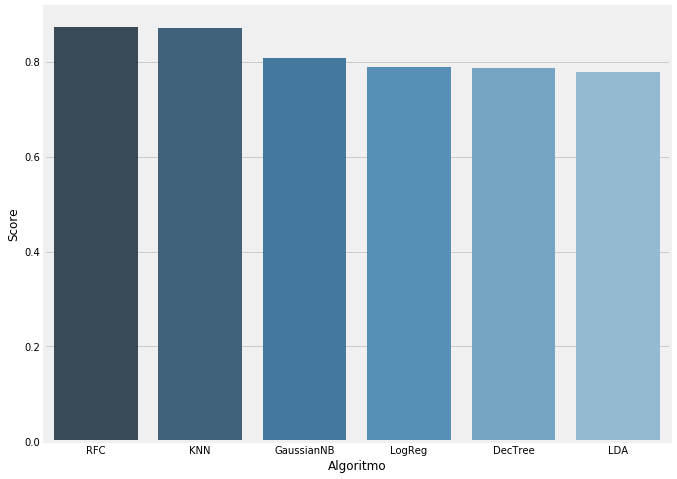

In [61]:
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='Algoritmo', y='Score', data=scoresDf, palette="Blues_d")

### **Rankeamos con los datos estandarizados/normalizados**

In [17]:
from sklearn.preprocessing import scale, normalize

In [18]:
X_train = scale(X_train)

/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [ ]:
%%time
scores = []
for name,model in models:
    print('################################',name,'################################')
    score = cv_score(model, X_train, target.values.ravel(), cv=kfold)
    scores.append((name,score))

################################ RFC ################################
[CV]  ................................................................
[CV] ....................... , score=0.8728884942941646, total=11.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.0min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8732271553166235, total=11.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 22.4min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8736933061809599, total=12.0min
################################ DecTree ################################


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 34.5min finished


[CV]  ................................................................
[CV] ....................... , score=0.7957925158542842, total= 6.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.7956958739449589, total= 4.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.3min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.7952139269874736, total= 4.5min
################################ LogReg ################################


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.8min finished


[CV]  ................................................................
[CV] ....................... , score=0.8715148693930757, total= 7.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8715144842732662, total=13.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 20.2min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8711818987341127, total=14.5min
################################ KNN ################################


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 34.7min finished


[CV]  ................................................................


In [ ]:
print('\n============== RANKING Scaled =================')
for name,score in sorted(scores,key=lambda x: x[1],reverse=True):
    print(name,':',score)

In [ ]:
X_train = normalize(X_train)

In [ ]:
%%time
scores = []
for name,model in models:
    print('################################',name,'################################')
    score = cv_score(model, X_train, target.values.ravel(), cv=kfold)
    scores.append((name,score))

In [ ]:
print('\n============== RANKING Normalized =================')
for name,score in sorted(scores,key=lambda x: x[1],reverse=True):
    print(name,':',score)

# Feature Selection

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
scoring = 'roc_auc'
seed = 7
def select_features(model,X,y):
    from sklearn.feature_selection import RFECV
    rfecv = RFECV(estimator=model, n_jobs=1, scoring=scoring, verbose=3)
    rfecv.fit(X, y)
    return rfecv.support_

In [7]:
best_models = []
best_models.append(('RFC',RandomForestClassifier(n_jobs=1)))
best_models.append(('KNN',KNeighborsClassifier()))
best_models.append(('DecTree',DecisionTreeClassifier()))

In [ ]:
%%time
best_features_mask = []
for name,model in best_models:
    print('##################################',name,'##################################')
    features = select_features(model, X_train, target.values.ravel())
    best_features_mask.append((name, features))

################################## RFC ##################################
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.


In [ ]:
for model_name,features_mask in best_features_mask:
    print('=================================',model_name,'=================================')
    print('number of features:',len(X_train.columns[features_mask]))
    print(X_train.columns[features_mask])

# Grid Search

In [18]:
scoring = 'roc_auc'
seed = 7
def select_params(model,params,X,y):
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    gs = GridSearchCV(model,params,cv=kfold,n_jobs=-1,verbose=3,scoring=scoring)
    #rs = RandomizedSearchCV(model,params, cv=kfold, n_jobs=2, verbose=3, scoring=scoring, random_state=seed)
    gs.fit(X,y)
    #rs.fit(X,y)
    return gs.best_params_
    #return rs.best_params_

In [30]:
# Solo para los mejores modelos
best_models = []
best_models.append(('RFC',RandomForestClassifier(n_jobs=1)))
best_models.append(('DecTree',DecisionTreeClassifier()))
best_models.append(('KNN',KNeighborsClassifier()))

In [31]:
%%time
from scipy.stats import randint, expon ,uniform, gamma, alpha
params = {}
params.update({'RFC':[{'n_estimators': [10, 12, 14]}]})
params.update({'DecTree':[{'min_samples_split': [2, 3, 4]}]})
params.update({'KNN':[{'leaf_size': [20,30,40]}, {'p': [1,2,3]}, {'weights': ['uniform', 'distance']}]})

best_params = []
for name, model in best_models:
    params = select_params(model,params[name], X_train, target.values.ravel())
    best_params.append((name, params))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] leaf_size=20 ....................................................
[CV] leaf_size=20 ....................................................
[CV] leaf_size=20 ....................................................
[CV] leaf_size=30 ....................................................
[CV] ........... leaf_size=30, score=0.8621915463631297, total= 3.3min
[CV] leaf_size=30 ....................................................
[CV] ........... leaf_size=20, score=0.8621596534077605, total= 3.4min
[CV] leaf_size=30 ....................................................
[CV] ........... leaf_size=20, score=0.8626297346609069, total= 3.4min
[CV] leaf_size=40 ....................................................
[CV] ........... leaf_size=20, score=0.8619422050796579, total= 3.3min
[CV] leaf_size=40 ....................................................
[CV] ........... leaf_size=30, score=0.8625699683657022, total= 2.8min
[CV] leaf_size=40

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 43.9min finished


CPU times: user 51 s, sys: 5.35 s, total: 56.4 s
Wall time: 44min 39s


In [32]:
# best_params_knn = [('KNN', {'p': 1})]
# best_params_dectree = [('DecTree', {'min_samples_split': 4})]
# best_params_rfc = [('RFC', {'n_estimators': 14})]
best_params

[('KNN', {'p': 1})]

In [29]:
best_params

[('DecTree', {'min_samples_split': 4})]

In [26]:
best_params

[('RFC', {'n_estimators': 14})]

# Predicciones

In [28]:
def predict(model,X_train,X_test,y):
    model.fit(X_train,y.values.ravel())
    return model.predict(X_test)

def pred_to_csv(prediction,name):
    test = pd.read_csv('test_.csv')
    df = pd.DataFrame(prediction,columns={'sepostulo'})
    df['id'] = test.id
    df = df.loc[:,['id','sepostulo']]
    df.sepostulo = df.sepostulo.astype(int)
    df.to_csv('pred_' + name + '.csv',index=False)

In [29]:
%%time
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pred = predict(RandomForestClassifier(), X_train, X_test, target)
pred_to_csv(pred,'RandomForestClassifier') # 0.77 score en kaggle

CPU times: user 5min 8s, sys: 4.42 s, total: 5min 12s
Wall time: 6min 14s


In [69]:
len(X_train)

8000000

In [31]:
X_train.dtypes

Administración                                    bool
AdministracióndePersonal                          bool
Almacén/Depósito/Expedición                       bool
AtenciónalCliente                                 bool
CallCenter                                        bool
Comercial                                         bool
Contabilidad                                      bool
CréditosyCobranzas                                bool
Gastronomia                                       bool
Legal                                             bool
Logística                                         bool
MantenimientoyLimpieza                            bool
Marketing                                         bool
Producción                                        bool
Recepcionista                                     bool
RecursosHumanos                                   bool
Secretaria                                        bool
Telemarketing                                     bool
Tesorería 

In [30]:
%%time
# KNN
from sklearn.neighbors import KNeighborsClassifier

pred = predict(KNeighborsClassifier(), X_train, X_test, target)
pred_to_csv(pred,'KNeighborsClassifier') # 0.76 score en kaggle

CPU times: user 9min 36s, sys: 11.1 s, total: 9min 47s
Wall time: 12min 8s


In [17]:
%%time
# SGD
from sklearn.linear_model import SGDClassifier

pred = predict(SGDClassifier(), X_train, X_test, target)
pred_to_csv(pred,'SGD')

/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


CPU times: user 1min 4s, sys: 26.1 s, total: 1min 30s
Wall time: 6min 57s


In [34]:
%%time
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

pred = predict(DecisionTreeClassifier(), X_train, X_test, target)
pred_to_csv(pred,'DecisionTreeClassifier') # 0.7 score en kaggle

CPU times: user 4min 20s, sys: 8.39 s, total: 4min 29s
Wall time: 5min 11s


In [12]:
print(X_train.shape)
print(X_test.shape)
print(target.shape)

(12000000, 45)
(100000, 45)
(12000000, 1)


# Entrega final

In [2]:
X_train = pd.read_csv('../data/X_train_8000000.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_8000000.csv', sep=',', encoding='utf-8')

In [3]:
X_test = pd.read_csv('../data/X_test.csv', sep=',', encoding='utf-8')

In [11]:
print(X_train.shape)
print(X_test.shape)
print(target.shape)

(8000000, 52)
(100120, 55)
(8000000, 1)


In [41]:
def train(model,X_train,X_test,y):
    model.fit(X_train,y.values.ravel())
    return model

def pred_to_csv(prediction,name):
    test = pd.read_csv('test_.csv')
    df = pd.DataFrame(prediction,columns={'sepostulo'})
    df['id'] = test.id
    df = df.loc[:,['id','sepostulo']]
    df.sepostulo = df.sepostulo.astype(int)
    df.to_csv('pred_' + name + '.csv',index=False)

In [38]:
X_train = pd.read_csv('../data/X_train_8000000_entrega1.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_8000000_entrega1.csv', sep=',', encoding='utf-8')

In [39]:
X_test = pd.read_csv('../data/X_test_entrega1.csv', sep=',', encoding='utf-8')

In [42]:
%%time
# Random Forest
from sklearn.ensemble import RandomForestClassifier

model = train(RandomForestClassifier(n_estimators=14), X_train, X_test, target)

CPU times: user 14min 17s, sys: 13.3 s, total: 14min 30s
Wall time: 17min 23s


In [ ]:
import pickle
filename = 'rfc_model.sav'

In [ ]:
%%time
pickle.dump(model, open(filename, 'wb')) # Export del modelo

In [ ]:
%%time
model = pickle.load(open(filename, 'rb'))

In [ ]:
%%time
pred = model.predict(X_test)
pred_to_csv(pred,'RandomForestClassifier')

In [38]:
X_train = pd.read_csv('../data/X_train_8000000_entrega1.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_8000000_entrega1.csv', sep=',', encoding='utf-8')

In [39]:
X_test = pd.read_csv('../data/X_test_entrega1.csv', sep=',', encoding='utf-8')

In [40]:
%%time
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pred = predict(RandomForestClassifier(), X_train, X_test, target)
pred_to_csv(pred,'RandomForestClassifier') # 0.77 score en kaggle

CPU times: user 10min 21s, sys: 12 s, total: 10min 33s
Wall time: 13min 28s
